## The PDE example

The PDE equation is:

$$\frac{\partial \phi}{\partial t}=-u\frac{\partial \phi}{\partial x}$$

With the initial value:
$$\phi_0 = \phi(x,0)$$

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# tf.compat.v1.disable_eager_execution()

# 1. Build model

## Model
https://weikaiwei.com/tf/tensorflow-2-mnist-2/

In [8]:
class solve_PDE_Model():
    def __init__(self, loss_calculator):
        self.loss_calculator = loss_calculator
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
        self.metrics = tf.keras.metrics.Mean(0.001)

        inputs = tf.keras.Input(shape=(2), name="inputs")
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer1')(inputs)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer2')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer3')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer4')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer5')(x)
        outputs = tf.keras.layers.Dense(units=1, name='output')(x)
    
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
            

    def predict(self, inputs):
        print("Start prediction")
        return self.model(inputs)

    def train(self, inputs, epochs):
        print("Start training")
        self.metrics.reset_states()

        for epoch in range(epochs):
            self.train_epoch(inputs)

            if(epoch%100 == 0):
                print("Epoch {0}, Loss {1}".format(epoch, self.metrics.result()))

    @tf.function
    def train_epoch(self, inputs):
        with tf.GradientTape() as tape:
            # Run forward
            phi = self.model(inputs)
            # Compute the loss value
            loss = self.loss_calculator.loss(inputs, phi)

        # Update metrics
        self.metrics.update_state(loss)

        # Compute gradients
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        #Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


## [Loss function](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)

In [9]:
class PDE_Loss():
    def __init__(self, phi_init, u, regularization_factor=0.1):
        self.phi_init = phi_init
        self.u = u

    def loss(self, inputs, phi):
        gradient = tf.gradients(phi, inputs)[0]
        phi_t, phi_x = tf.unstack(gradient,axis=1)
        
        phi_t = tf.reshape(phi_t, [phi_t.shape[0],1])
        phi_x = tf.reshape(phi_x, [phi_x.shape[0],1])
        
        governing_Eq = phi_t+self.u+phi_x
        
        init_size = self.phi_init.shape[0]

        number_of_time_step = governing_Eq.shape[0] / init_size
        
        loss = tf.reduce_mean(tf.square(phi[:init_size]-self.phi_init)) 

        for one_time_step in range(1, int(number_of_time_step)):
                    
            loss += tf.reduce_sum(tf.square(
                # governing_Eq in loss   
                governing_Eq[one_time_step*init_size+1:(one_time_step+1)*init_size-1]
            ))
    
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[one_time_step*init_size][0]-1.0) 
            ))
        
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[(one_time_step+1)*init_size-1][0]-1.0)
            ))
                

        return loss
    


In [10]:

lx = 2
nx = 20
dx = lx / (nx-1)

lt = 0.05
nt = 3
dt = lt / (nt-1)

u = 1      #assume wavespeed of u = 1

# sine wave init
phi_init = np.ones(nx)

sineWave = np.linspace(0,2*np.pi, int(1.5 / dx + 1) - int(.5 / dx) )
phi_init[int(.5 / dx):int(1.5 / dx + 1)] += np.sin(sineWave)

phi_init = phi_init.reshape(phi_init.shape[0],-1)
phi_init = tf.constant(phi_init, dtype=tf.float32)

x_all = np.linspace(0, lx, nx)
x_all = tf.constant(x_all, dtype=tf.float32)

t_all = np.linspace(0, lt, nt)
t_all = tf.constant(t_all, dtype=tf.float32)

def combine(x, y):
  xx, yy = tf.meshgrid(x, y, indexing='ij')
  return tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)

inputs_all = combine(t_all,x_all)

loss_calculator = PDE_Loss(phi_init,u)

myModel = solve_PDE_Model(loss_calculator)
myModel.train(inputs_all,50000)


Start training
train_epoch
train_epoch
Epoch 0, Loss 57.085750579833984
Epoch 100, Loss 20.84607696533203
Epoch 200, Loss 10.834948539733887
Epoch 300, Loss 7.324222087860107
Epoch 400, Loss 5.5603928565979
Epoch 500, Loss 4.500655174255371
Epoch 600, Loss 3.7935538291931152
Epoch 700, Loss 3.2881932258605957
Epoch 800, Loss 2.90901517868042
Epoch 900, Loss 2.6140053272247314
Epoch 1000, Loss 2.3779239654541016
Epoch 1100, Loss 2.184718608856201
Epoch 1200, Loss 2.0236873626708984
Epoch 1300, Loss 1.8874109983444214
Epoch 1400, Loss 1.7705888748168945
Epoch 1500, Loss 1.6693326234817505
Epoch 1600, Loss 1.58072030544281
Epoch 1700, Loss 1.5025173425674438
Epoch 1800, Loss 1.432998776435852
Epoch 1900, Loss 1.3707941770553589
Epoch 2000, Loss 1.3148068189620972
Epoch 2100, Loss 1.2641490697860718
Epoch 2200, Loss 1.2180945873260498
Epoch 2300, Loss 1.1760380268096924
Epoch 2400, Loss 1.137479305267334
Epoch 2500, Loss 1.1020041704177856
Epoch 2600, Loss 1.0692566633224487
Epoch 2700, Lo

In [11]:
result = myModel.predict(inputs_all)

Start prediction


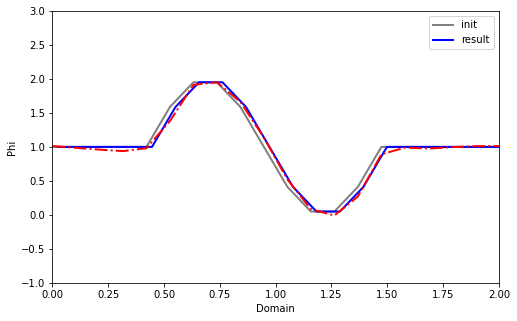

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
ax1.set_xlim((0, 2))            
ax1.set_ylim((-1, 3))
ax1.set_xlabel('Domain')
ax1.set_ylabel('Phi')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
n=1
txt_title = ax1.set_title('')
line1, = ax1.plot(x_all, phi_init, 'gray', lw=2)     # ax.plot returns a list of 2D line objects
line1, = ax1.plot(x_all+dt*n*u, phi_init, 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot(x_all, result[n*nx:(n+1)*nx], 'r-.', lw=2)     # ax.plot returns a list of 2D line objects
ax1.legend(['init','result'])